In [1]:
import scanpy as sc

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pylab as plt
from scipy import stats
import skimage.filters as skif
from sklearn.preprocessing import normalize
import glob
import os
import QCPipe
import dropkick as dk
import seaborn as sns

In [3]:
adata = sc.read_h5ad('GSM3305227_Tumor_1_Full.h5ad')

In [34]:
print(adata)

AnnData object with n_obs × n_vars = 1206 × 25507


In [40]:
adata.X

array([[ 0.,  1.,  1., ...,  3., 29.,  0.],
       [ 0.,  2.,  0., ...,  8., 26.,  0.],
       [ 0.,  2.,  1., ...,  4., 19.,  0.],
       ...,
       [ 0.,  1.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  4.,  0., ...,  0.,  1.,  0.]], dtype=float32)

In [41]:
adata.X.sum(axis=1)

array([41659., 26777., 25769., ...,  1024.,  1005.,  1237.], dtype=float32)

In [42]:
sc.pp.normalize_total(adata)
adata.X = np.arcsinh(adata.X).copy()
sc.pp.scale(adata)

In [43]:
adata.X

array([[-0.05946521, -0.41953042,  0.02996312, ..., -0.3932026 ,
         0.18577212, -0.13756137],
       [-0.05946521, -0.28825733, -0.27226427, ...,  0.43774483,
         0.47934684, -0.13756137],
       [-0.05946521, -0.2808065 ,  0.21556213, ..., -0.05931247,
         0.235544  , -0.13756137],
       ...,
       [-0.05946521,  1.04291   , -0.27226427, ..., -0.6984315 ,
         0.4845017 , -0.13756137],
       [-0.05946521, -0.4824658 , -0.27226427, ..., -0.6984315 ,
        -1.2679867 , -0.13756137],
       [-0.05946521,  2.0092986 , -0.27226427, ..., -0.6984315 ,
         0.316134  , -0.13756137]], dtype=float32)

In [44]:
sc.set_figure_params(dpi=200)

In [45]:
adata.var_names

Index(['0610006L08Rik', '0610007P14Rik', '0610009B22Rik', '0610009E02Rik',
       '0610009L18Rik', '0610009O20Rik', '0610010F05Rik', '0610010K14Rik',
       '0610011F06Rik', '0610012D04Rik',
       ...
       'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4',
       'mt-Nd4l', 'mt-Nd5', 'mt-Nd6'],
      dtype='object', length=25507)

In [46]:
adata.raw = adata

In [48]:
adata.var['Mitochondrial'] = adata.var.index.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata,qc_vars=['Mitochondrial'],use_raw=True,inplace=True)

/home/andy/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [49]:
sc.pp.pca(adata,random_state=0)

In [50]:
neighborhood_k = np.sqrt(adata.n_obs).astype(int) #We have found that scaling the K to equal the square root of the total number of neighbors to be effective
sc.pp.neighbors(adata,n_neighbors=neighborhood_k,use_rep='X_pca',random_state=0) #Calculate this KNN based off of the PCA distances

In [51]:
sc.tl.umap(adata,min_dist=0.25,random_state=0)

In [52]:
sc.tl.leiden(adata,resolution=2,random_state=0) #Here we use a resolution of 2, which should yield 30+ clusters. This step may take a while.

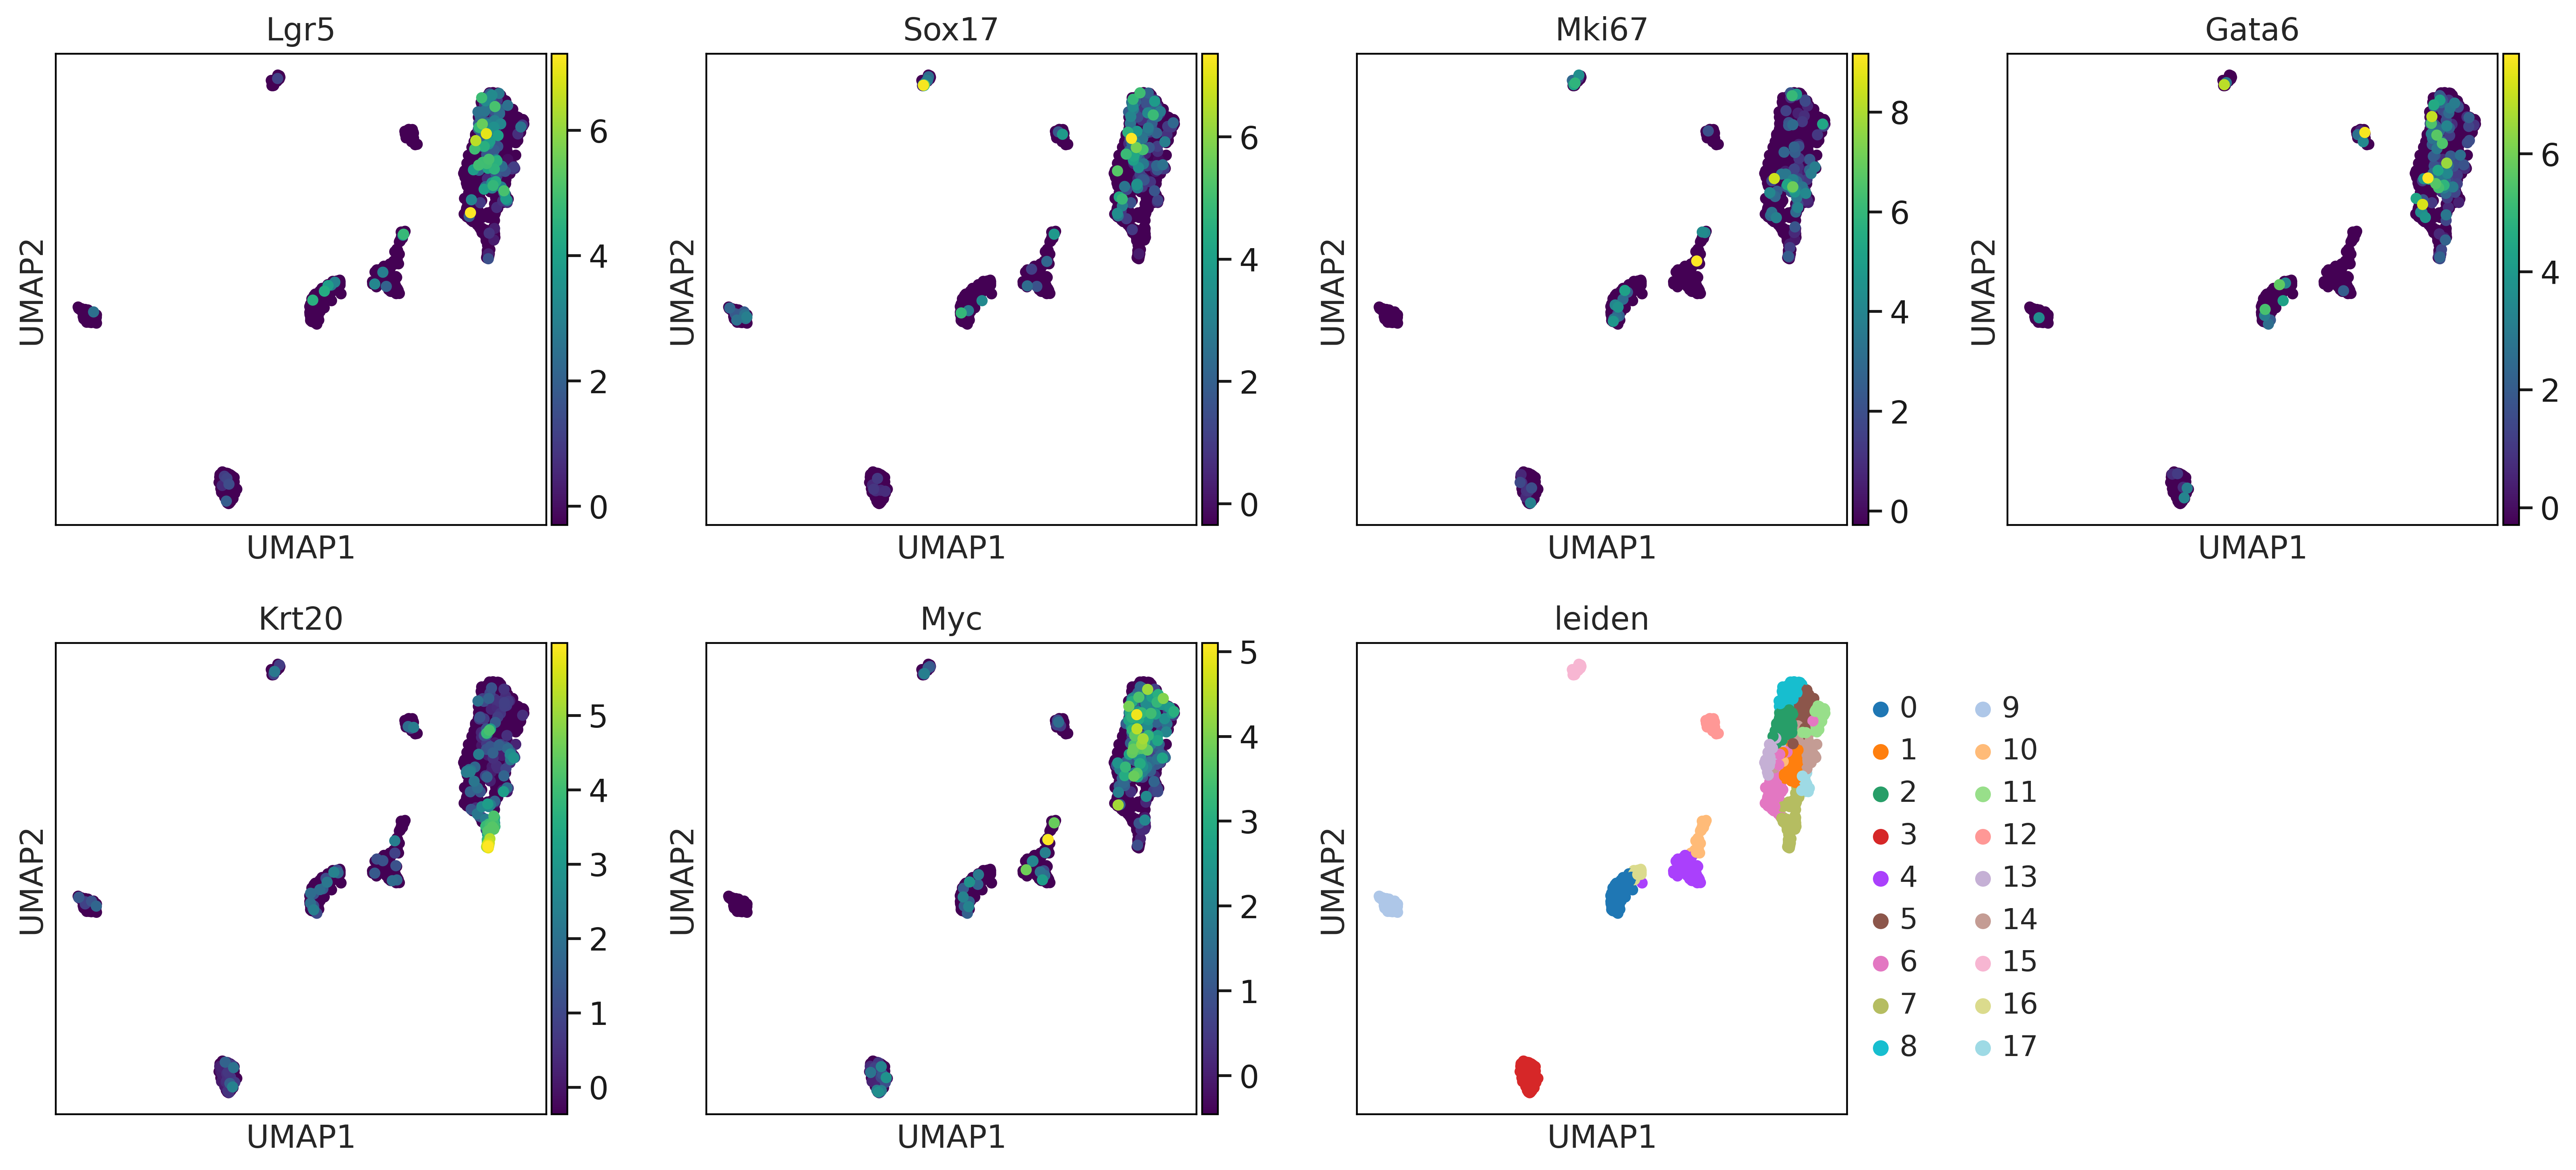

In [53]:
sc.pl.umap(adata,color=['Lgr5','Sox17','Mki67','Gata6','Krt20','Myc','leiden'],use_raw=False,cmap='viridis')

In [54]:
#Differential gene expression testing using the .raw values
sc.tl.rank_genes_groups(adata,groupby='leiden',use_raw=True,n_genes=200,method='wilcoxon')

/home/andy/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


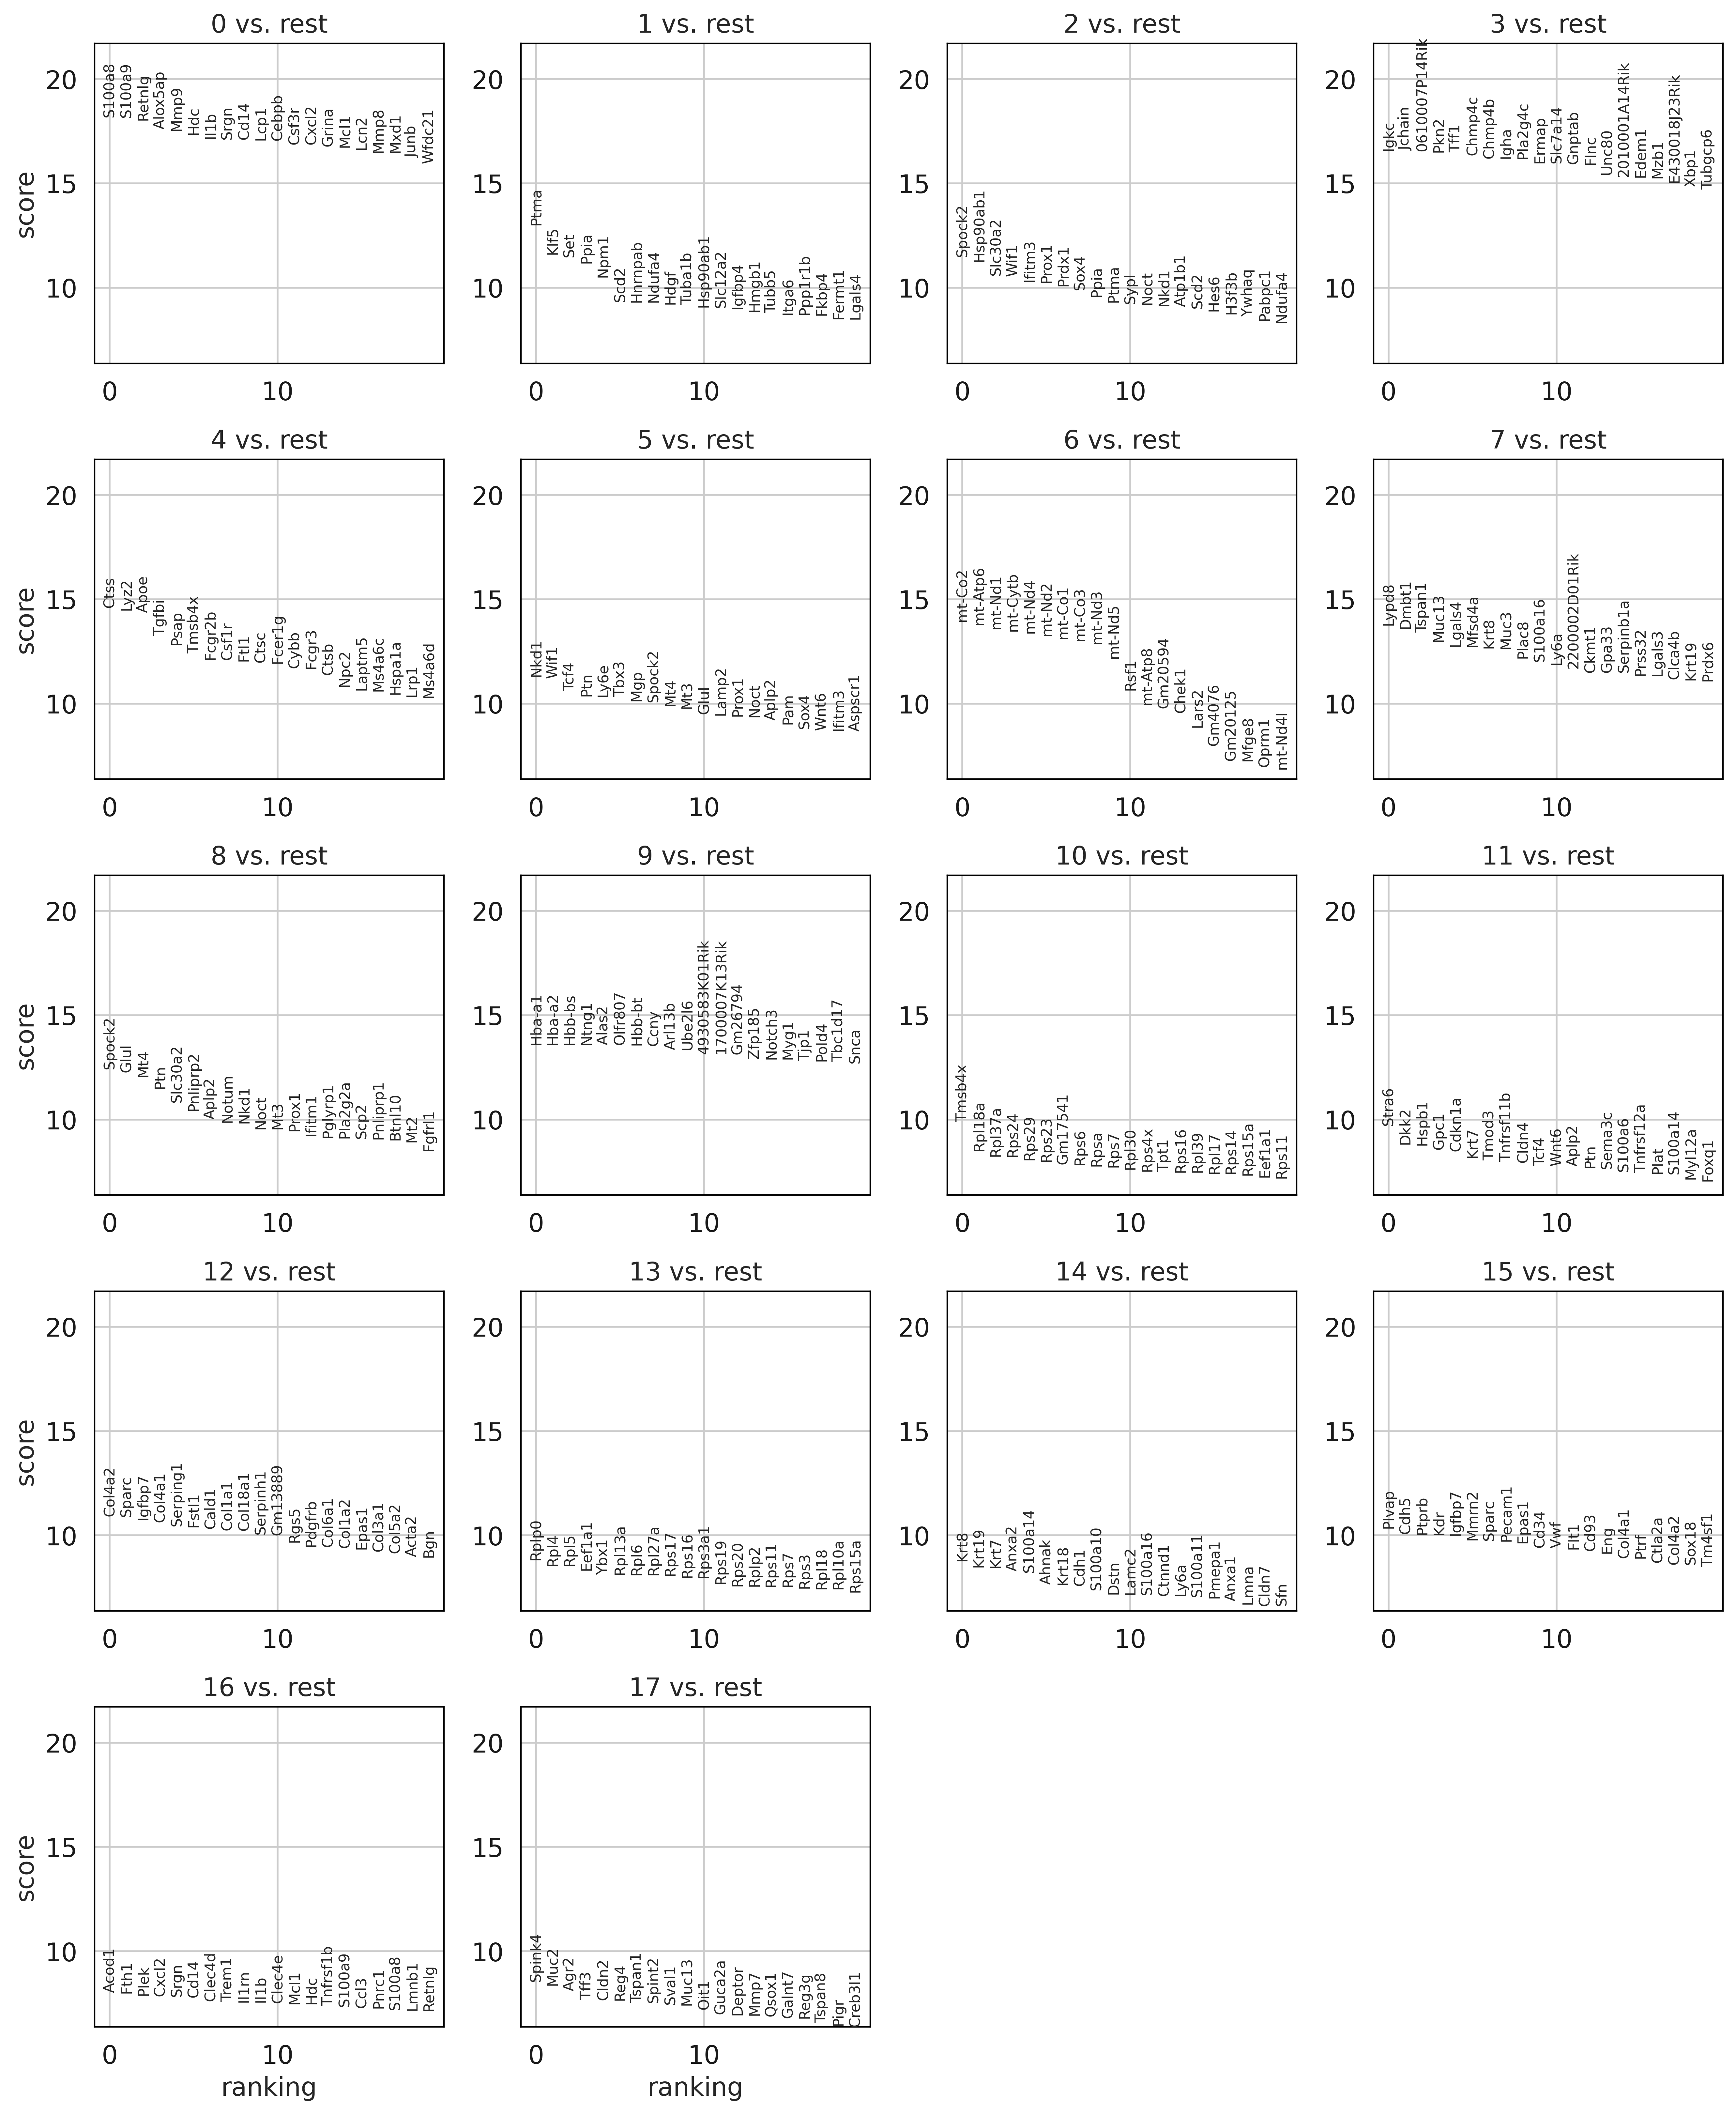

In [55]:
#Show differential gene expression results
sc.pl.rank_genes_groups(adata)

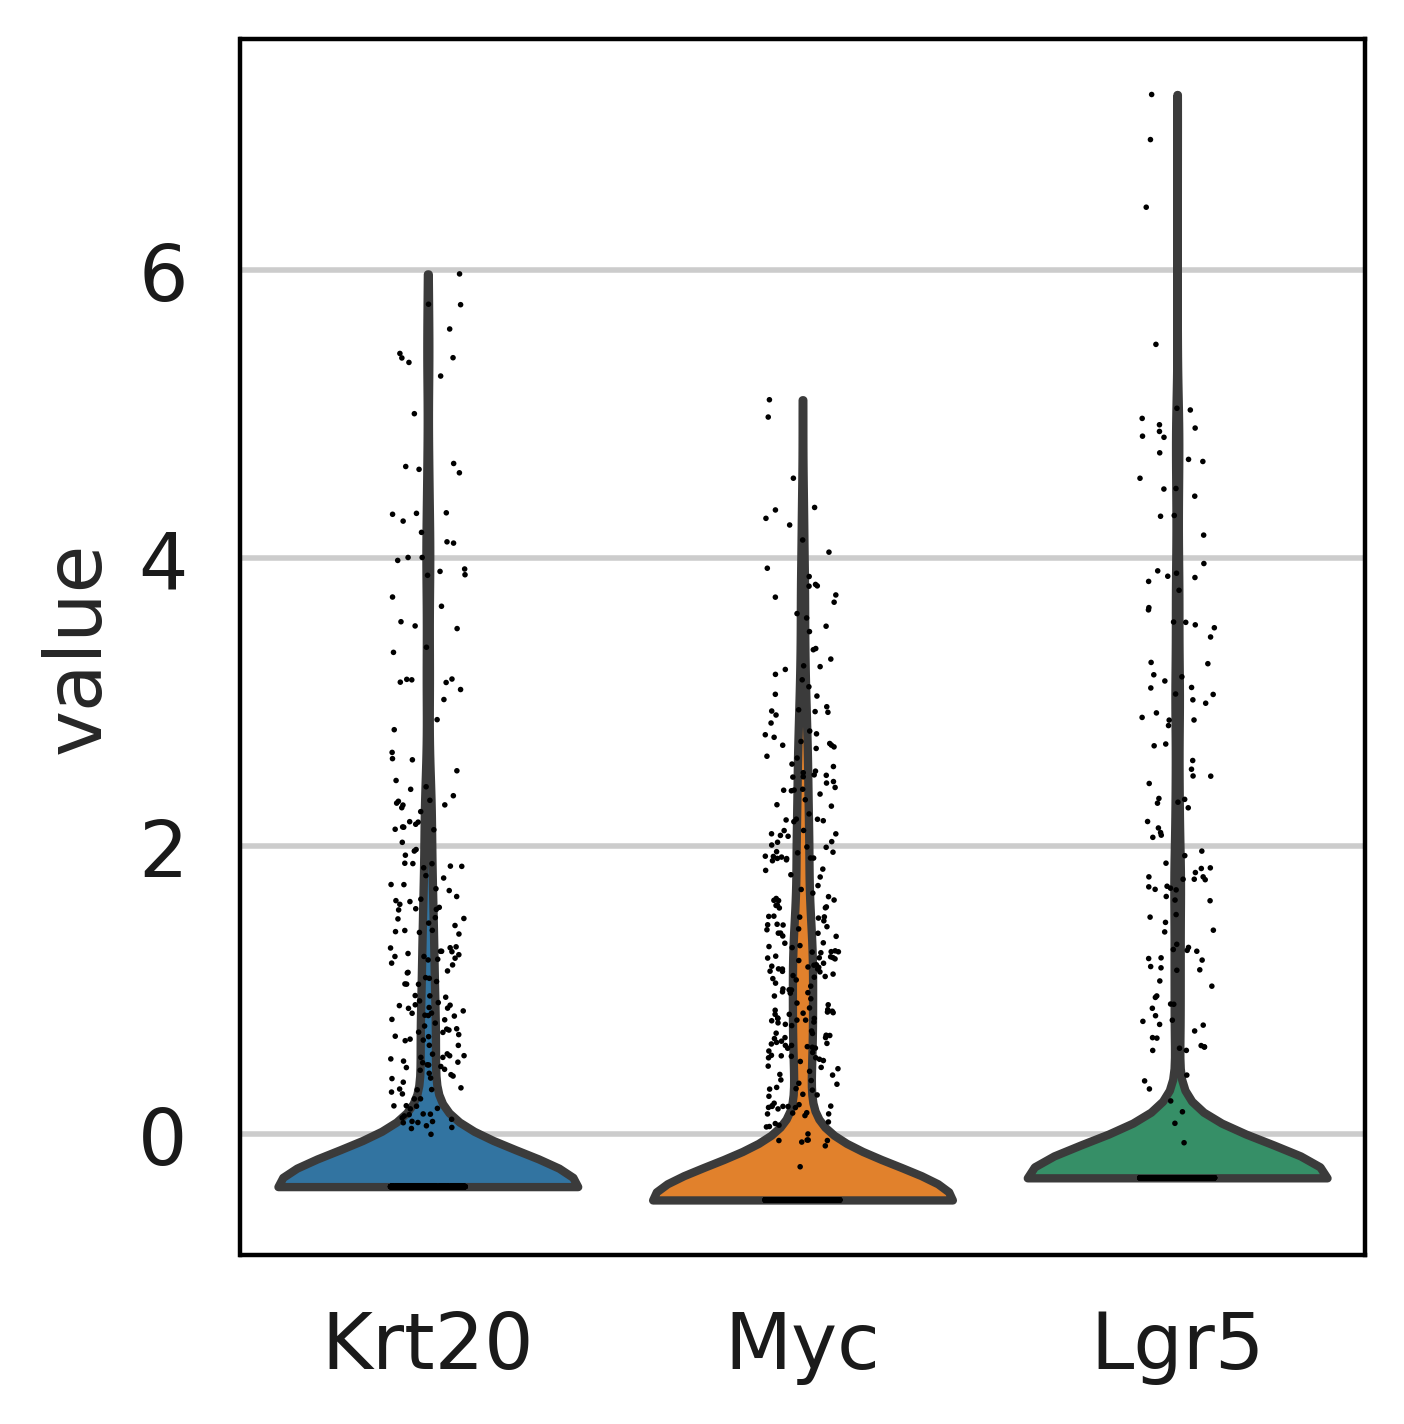

In [56]:
sc.pl.violin(adata,keys=['Krt20','Myc','Lgr5'],use_raw=False)

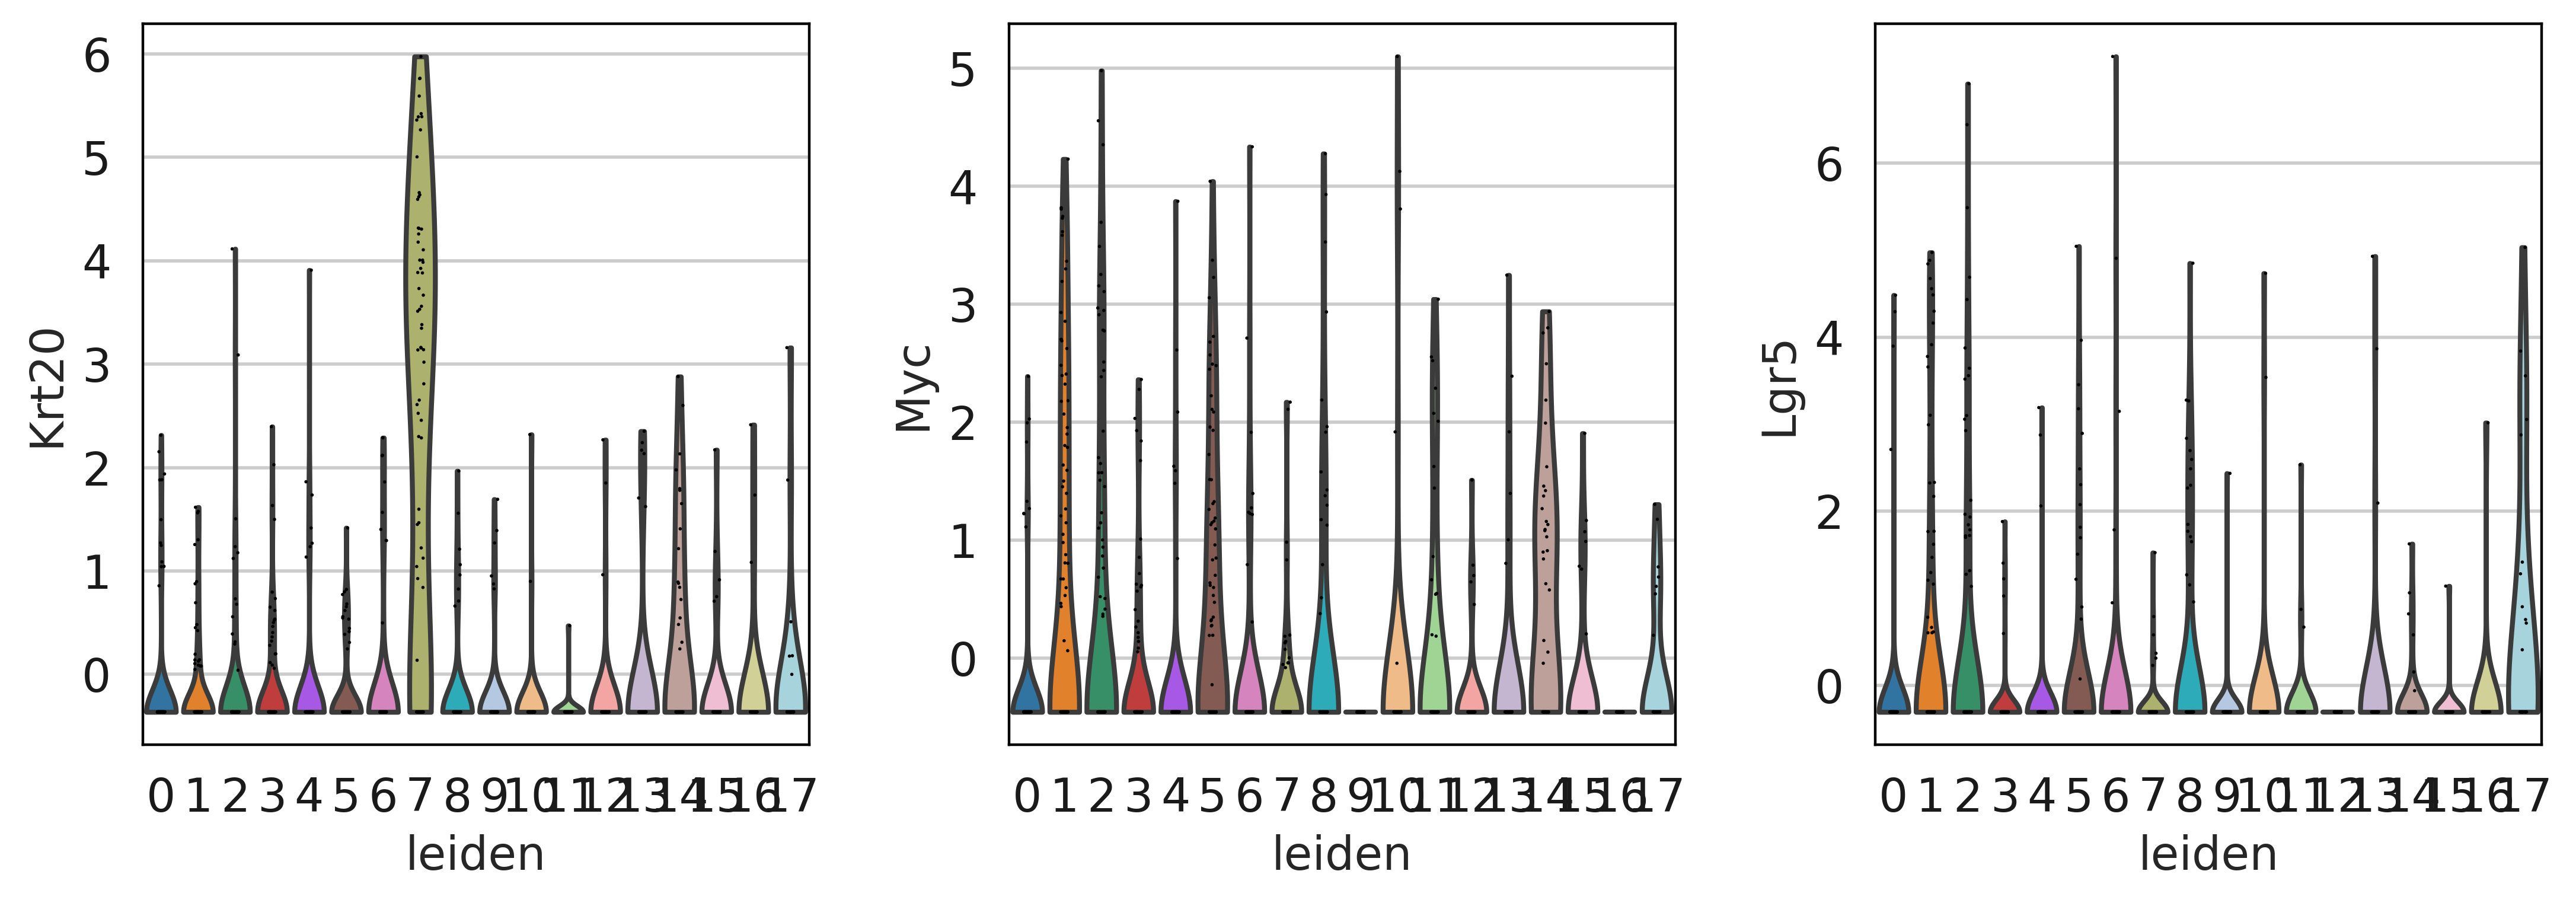

In [22]:
sc.pl.violin(adata,keys=['Krt20','Myc','Lgr5'],groupby='leiden',use_raw=False)

In [24]:
adata

AnnData object with n_obs × n_vars = 1206 × 25507
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mitochondrial', 'log1p_total_counts_Mitochondrial', 'pct_counts_Mitochondrial', 'leiden'
    var: 'mean', 'std', 'Mitochondrial', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

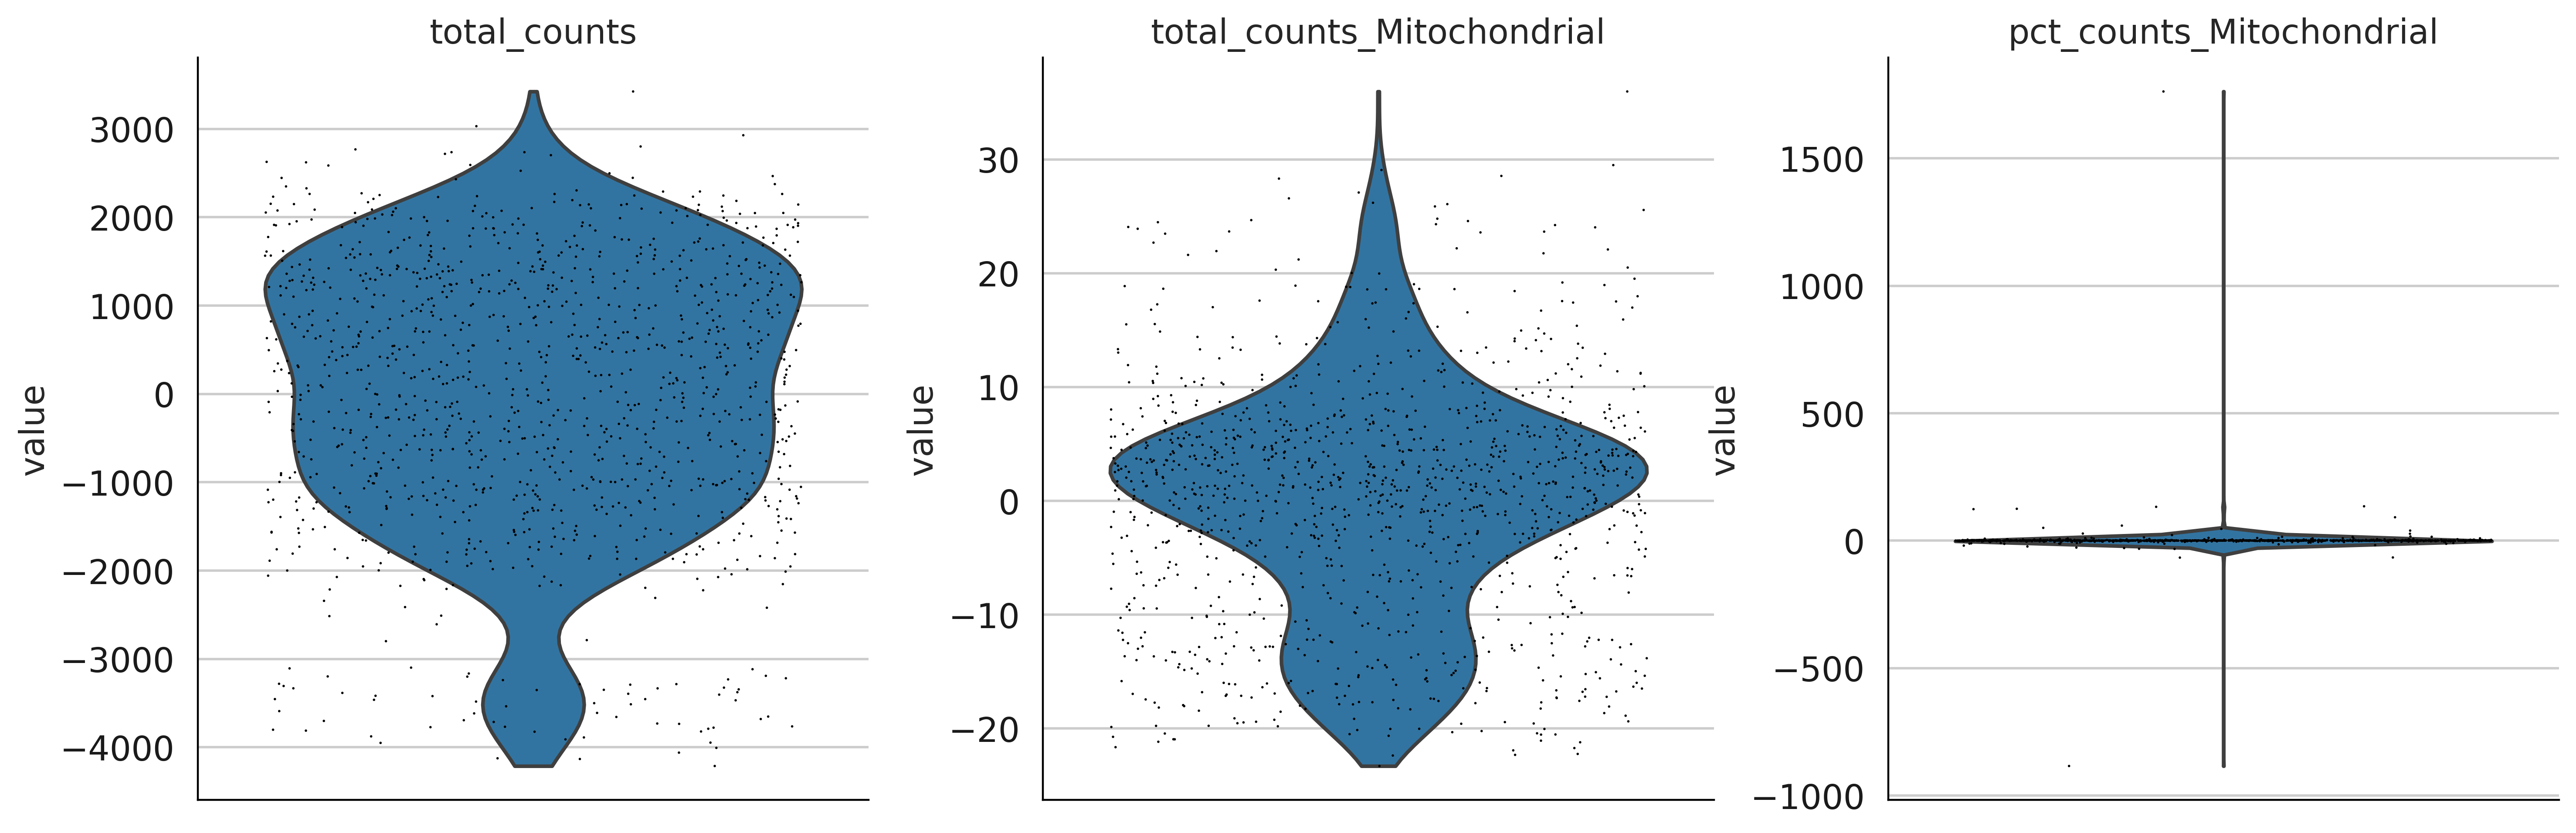

In [31]:
sc.pl.violin(adata,keys=['total_counts','total_counts_Mitochondrial','pct_counts_Mitochondrial'],jitter=0.4,multi_panel=True)

In [32]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0        1         2              3       4       5        6  \
0   S100a8     Ptma    Spock2           Igkc    Ctss    Nkd1   mt-Co2   
1   S100a9     Klf5  Hsp90ab1         Jchain    Lyz2    Wif1  mt-Atp6   
2   Retnlg      Set   Slc30a2  0610007P14Rik    Apoe    Tcf4   mt-Nd1   
3  Alox5ap     Ppia      Wif1           Pkn2   Tgfbi     Ptn  mt-Cytb   
4     Mmp9     Npm1    Ifitm3           Tff1    Psap    Ly6e   mt-Nd4   
5      Hdc     Scd2     Prox1         Chmp4c  Tmsb4x    Tbx3   mt-Nd2   
6     Il1b  Hnrnpab     Prdx1         Chmp4b  Fcgr2b     Mgp   mt-Co1   
7     Srgn   Ndufa4      Sox4           Igha   Csf1r  Spock2   mt-Co3   
8     Cd14     Hdgf      Ppia        Pla2g4c    Ftl1     Mt4   mt-Nd3   
9     Lcp1   Tuba1b      Ptma          Ermap    Ctsc     Mt3   mt-Nd5   

         7         8        9       10         11        12      13       14  \
0    Lypd8    Spock2   Hba-a1   Tmsb4x      Stra6    Col4a2   Rplp0     Krt8   
1    Dmbt1      Glul   Hba-a2   Rpl18a       Dkk2     Sparc    Rpl4    Krt19   
2   Tspan1       Mt4   Hbb-bs   Rpl37a      Hspb1    Igfbp7    Rpl5     Krt7   
3    Muc13       Ptn    Ntng1    Rps24       Gpc1    Col4a1  Eef1a1    Anxa2   
4   Lgals4   Slc30a2    Alas2    Rps29     Cdkn1a  Serping1    Ybx1  S100a14   
5   Mfsd4a  Pnliprp2  Olfr807    Rps23       Krt7     Fstl1  Rpl13a    Ahnak   
6     Krt8     Aplp2   Hbb-bt  Gm17541      Tmod3     Cald1    Rpl6    Krt18   
7     Muc3     Notum     Ccny     Rps6  Tnfrsf11b    Col1a1  Rpl27a     Cdh1   
8    Plac8      Nkd1   Arl13b     Rpsa      Cldn4   Col18a1   Rps17  S100a10   
9  S100a16      Noct   Ube2l6     Rps7       Tcf4  Serpinh1   Rps16     Dstn   

       15      16      17  
0   Plvap   Acod1  Spink4  
1    Cdh5    Fth1    Muc2  
2   Ptprb    Plek    Agr2  
3     Kdr   Cxcl2    Tff3  
4  Igfbp7    Srgn   Cldn2  
5   Mmrn2    Cd14    Reg4  
6   Sparc  Clec4d  Tspan1  
7  Pecam1   Trem1  Spint2  
8   Epas1   Il1rn   Sval1  
9    Cd34    Il1b   Muc13